In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
class Reshape(nn.Module):
    """Reshape layer.
    Parameters
    ----------
    shape: List[int]
        Dimensions after number of batches.
    """

    def __init__(self, shape):
        """Initialize."""
        super().__init__()
        self.shape = shape

    def forward(self, x):
        """Perform forward.
        Parameters
        ----------
        x: Tensor
            Input batch.
        Returns
        -------
        Tensor:
            Preprocessed input batch.
        """
        return x.view(x.size(0), *self.shape)

In [ ]:
import torch
from torch import nn


class BarGenerator(nn.Module):
    n_steps_per_bar = 16
    n_pitches = 84

    def __init__(
        self,
        z_dimension: int = 32,
        hid_features: int = 1024,
        hid_channels: int = 512,
        out_channels: int = 1
    ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4 * z_dimension, hid_features),
            nn.BatchNorm1d(hid_features),
            nn.ReLU(inplace=True),
            Reshape(shape=[hid_channels, hid_features // hid_channels, 1]),
            nn.ConvTranspose2d(
                hid_channels,
                hid_channels,
                kernel_size=(2, 1),
                stride=(2, 1),
                padding=0,
            ),
            nn.BatchNorm2d(hid_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                hid_channels,
                hid_channels // 2,
                kernel_size=(2, 1),
                stride=(2, 1),
                padding=0,
            ),
            nn.BatchNorm2d(hid_channels // 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                hid_channels // 2,
                hid_channels // 2,
                kernel_size=(2, 1),
                stride=(2, 1),
                padding=0,
            ),
            nn.BatchNorm2d(hid_channels // 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                hid_channels // 2,
                hid_channels // 2,
                kernel_size=(1, 7),
                stride=(1, 7),
                padding=0,
            ),
            nn.BatchNorm2d(hid_channels // 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                hid_channels // 2,
                out_channels,
                kernel_size=(1, 12),
                stride=(1, 12),
                padding=0,
            ),
            Reshape(shape=[1, 1, self.n_steps_per_bar, self.n_pitches])
        )

    def forward(self, x):
        fx = self.net(x)
        return fx

In [ ]:
class TemporalNetwork(nn.Module):
    n_bars = 2

    def __init__(
        self,
        z_dimension: int = 32,
        hid_channels: int = 1024,
    ):
        super().__init__()
        self.net = nn.Sequential(
            Reshape(shape=[z_dimension, 1, 1]),
            nn.ConvTranspose2d(
                z_dimension,
                hid_channels,
                kernel_size=(2, 1),
                stride=(1, 1),
                padding=0,
            ),
            nn.BatchNorm2d(hid_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                hid_channels,
                z_dimension,
                kernel_size=(self.n_bars - 1, 1),
                stride=(1, 1),
                padding=0,
            ),
            nn.BatchNorm2d(z_dimension),
            nn.ReLU(inplace=True),
            Reshape(shape=[z_dimension, self.n_bars]),
        )

    def forward(self, x):
        fx = self.net(x)
        return fx

In [ ]:
"""Muse Generator."""
import torch
from torch import nn


class MuseGenerator(nn.Module):
    """Muse generator.
    Parameters
    ----------
    z_dimension: int, (default=32)
        Noise space dimension.
    hid_channels: int, (default=1024)
        Number of hidden channels.
    hid_features: int, (default=1024)
        Number of hidden features.
    out_channels: int, (default=1)
        Number of output channels.
    """

    n_tracks = 4
    n_bars = 2
    n_steps_per_bar = 16
    n_pitches = 84

    def __init__(
        self,
        z_dimension: int = 32,
        hid_channels: int = 1024,
        hid_features: int = 1024,
        out_channels: int = 1,
    ) :
        """Initialize."""
        super().__init__()
        # chords generator
        self.chords_network = TemporalNetwork(z_dimension, hid_channels)
        # melody generators
        self.melody_networks = nn.ModuleDict({})
        for n in range(self.n_tracks):
            self.melody_networks.add_module(
                "melodygen_" + str(n),
                TemporalNetwork(z_dimension, hid_channels),
            )
        # bar generators
        self.bar_generators = nn.ModuleDict({})
        for n in range(self.n_tracks):
            self.bar_generators.add_module(
                "bargen_" + str(n),
                BarGenerator(
                    z_dimension,
                    hid_features,
                    hid_channels // 2,
                    out_channels
                )
            )
        # musegan generator compiled

    def forward(self, chords, style, melody, groove):
        """Perform forward.
        Parameters
        ----------
        chords: Tensor
            Chords.
        style: Tensor
            Style.
        melody: Tensor
            Melody.
        groove: Tensor
            Groove.
        Returns
        -------
        Tensor:
            Preprocessed input batch.
        """
        # chords shape: (batch_size, z_dimension)
        # style shape: (batch_size, z_dimension)
        # melody shape: (batch_size, n_tracks, z_dimension)
        # groove shape: (batch_size, n_tracks, z_dimension)
        chord_outs = self.chords_network(chords)
        bar_outs = []
        for bar in range(self.n_bars):
            track_outs = []
            chord_out = chord_outs[:, :, bar]
            style_out = style
            for track in range(self.n_tracks):
                melody_in = melody[:, track, :]
                melody_out = self.melody_networks["melodygen_" + str(track)](melody_in)[:, :, bar]
                groove_out = groove[:, track, :]
                z = torch.cat([chord_out, style_out, melody_out, groove_out], dim=1)
                track_outs.append(self.bar_generators["bargen_" + str(track)](z))
            track_out = torch.cat(track_outs, dim=1)
            bar_outs.append(track_out)
        out = torch.cat(bar_outs, dim=2)
        # out shape: (batch_size, n_tracks, n_bars, n_steps_per_bar, n_pitches)
        return out

In [ ]:
generator = MuseGenerator(z_dimension=32, hid_channels=1024, hid_features=1024, out_channels=1).to(device)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))

In [ ]:
class MuseCritic(nn.Module):
    n_tracks = 4
    n_bars = 2
    n_steps_per_bar = 16
    n_pitches = 84

    def __init__(
        self,
        hid_channels: int = 128,
        hid_features: int = 1024,
        out_features: int = 1,
    ) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(self.n_tracks, hid_channels, (2, 1, 1), (1, 1, 1), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, hid_channels, (self.n_bars - 1, 1, 1), (1, 1, 1), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, hid_channels, (1, 1, 12), (1, 1, 12), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, hid_channels, (1, 1, 7), (1, 1, 7), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, hid_channels, (1, 2, 1), (1, 2, 1), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, hid_channels, (1, 2, 1), (1, 2, 1), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, 2 * hid_channels, (1, 4, 1), (1, 2, 1), padding=(0, 1, 0)),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(2 * hid_channels, 4 * hid_channels, (1, 3, 1), (1, 2, 1), padding=(0, 1, 0)),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Flatten(),
            nn.Linear(4 * hid_channels, hid_features),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Linear(hid_features, out_features)
        )

    def forward(self, x):
        fx = self.net(x)
        return fx

In [ ]:
critic = MuseCritic(hid_channels=128,
                    hid_features=1024,
                    out_features=1).to(device)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.001, betas=(0.5, 0.9))

In [ ]:
from torch.utils.data import Dataset
import numpy as np
from music21 import midi
from music21 import converter
from music21 import note, stream, duration, tempo
class MidiDataset(Dataset):
    def __init__(
        self,
        path,
        split= "train",
        n_bars= 2,
        n_steps_per_bar= 16,
    ):
        self.n_bars = n_bars
        self.n_steps_per_bar = n_steps_per_bar
        dataset = np.load(path, allow_pickle=True, encoding="bytes")[split]
        self.data_binary, self.data_ints, self.data = self.__preprocess__(dataset)

    def __len__(self):
        return len(self.data_binary)

    def __getitem__(self, index):
        return torch.from_numpy(self.data_binary[index]).float()

    def __preprocess__(self, data):
        data_ints = []
        for x in data:
            skip = True
            skip_rows = 0
            while skip:
                if not np.any(np.isnan(x[skip_rows: skip_rows + 4])):
                    skip = False
                else:
                    skip_rows += 4
            if self.n_bars * self.n_steps_per_bar < x.shape[0]:
                data_ints.append(x[skip_rows: self.n_bars * self.n_steps_per_bar + skip_rows, :])
        data_ints = np.array(data_ints)
        self.n_songs = data_ints.shape[0]
        self.n_tracks = data_ints.shape[2]
        data_ints = data_ints.reshape([self.n_songs, self.n_bars, self.n_steps_per_bar, self.n_tracks])
        max_note = 83
        mask = np.isnan(data_ints)
        data_ints[mask] = max_note + 1
        max_note = max_note + 1
        data_ints = data_ints.astype(int)
        num_classes = max_note + 1
        data_binary = np.eye(num_classes)[data_ints]
        data_binary[data_binary == 0] = -1
        data_binary = np.delete(data_binary, max_note, -1)
        data_binary = data_binary.transpose([0, 3, 1, 2, 4])
        return data_binary, data_ints, data


def binarise_output(output):
    max_pitches = np.argmax(output, axis=-1)
    return max_pitches


def postprocess(
    output,
    n_tracks= 4,
    n_bars= 2,
    n_steps_per_bar= 16,
):
    parts = stream.Score()
    parts.append(tempo.MetronomeMark(number=66))
    max_pitches = binarise_output(output)
    midi_note_score = np.vstack([
        max_pitches[i].reshape([n_bars * n_steps_per_bar, n_tracks]) for i in range(len(output))
    ])
    for i in range(n_tracks):
        last_x = int(midi_note_score[:, i][0])
        s = stream.Part()
        dur = 0
        for idx, x in enumerate(midi_note_score[:, i]):
            x = int(x)
            if (x != last_x or idx % 4 == 0) and idx > 0:
                n = note.Note(last_x)
                n.duration = duration.Duration(dur)
                s.append(n)
                dur = 0
            last_x = x
            dur = dur + 0.25
        n = note.Note(last_x)
        n.duration = duration.Duration(dur)
        s.append(n)
        parts.append(s)
    return parts

In [ ]:
from torch.utils.data import DataLoader
dataset = MidiDataset(path='/content/Jsb16thSeparated.npz')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

In [ ]:
def initialize_weights(layer, mean= 0.0, std= 0.02):
    """Initialize module with normal distribution.
    Parameters
    ----------
    layer: nn.Module
        Layer.
    mean: float, (default=0.0)
        Mean value.
    std: float, (default=0.02)
        Standard deviation value.
    """
    if isinstance(layer, (nn.Conv3d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(layer.weight, mean, std)
    elif isinstance(layer, (nn.Linear, nn.BatchNorm2d)):
        torch.nn.init.normal_(layer.weight, mean, std)
        torch.nn.init.constant_(layer.bias, 0)

In [ ]:
generator = generator.apply(initialize_weights)
critic = critic.apply(initialize_weights)

In [ ]:
class WassersteinLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_target):
        loss = - torch.mean(y_pred * y_target)
        return loss


class GradientPenalty(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, outputs):
        grad = torch.autograd.grad(
            inputs=inputs,
            outputs=outputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True,
            retain_graph=True,
        )[0]
        grad_ = torch.norm(grad.view(grad.size(0), -1), p=2, dim=1)
        penalty = torch.mean((1. - grad_) ** 2)
        return penalty

In [ ]:
from tqdm import tqdm
batch_size= 64
display_step = 10
alpha = torch.rand((batch_size, 1, 1, 1, 1)).requires_grad_().to(device)
data = {
  "gloss": [],
  "closs": [],
  "cfloss": [],
  "crloss": [],
  "cploss": [],
}
gen_criterion = WassersteinLoss().to(device)
critic_criterion = WassersteinLoss().to(device)
critic_penalty = GradientPenalty().to(device)
generator = generator.to(device)
epochs = 500
repeat = 5
critic = critic.to(device)
for epoch in tqdm(range(epochs)):
  e_gloss = 0
  e_cfloss = 0
  e_crloss = 0
  e_cploss = 0
  e_closs = 0
  for real in dataloader:
    real = real.to(device)
    # Train Critic
    b_closs = 0
    b_cfloss = 0
    b_crloss = 0
    b_cploss = 0
    for _ in range(repeat):
      cords = torch.randn(batch_size, 32).to(device)
      style = torch.randn(batch_size, 32).to(device)
      melody = torch.randn(batch_size, 4, 32).to(device)
      groove = torch.randn(batch_size, 4, 32).to(device)
      critic_optimizer.zero_grad()
      with torch.no_grad():
        fake = generator(cords, style, melody, groove).detach()
      realfake = alpha * real + (1. - alpha) * fake
      fake_pred = critic(fake)
      real_pred = critic(real)
      realfake_pred = critic(realfake)
      fake_loss = critic_criterion(fake_pred, - torch.ones_like(fake_pred))
      real_loss = critic_criterion(real_pred, torch.ones_like(real_pred))
      penalty = critic_penalty(realfake, realfake_pred)
      closs = fake_loss + real_loss + 10 * penalty
      closs.backward(retain_graph=True)
      critic_optimizer.step()
      b_cfloss += fake_loss.item() / repeat
      b_crloss += real_loss.item() / repeat
      b_cploss += 10 * penalty.item() / repeat
      b_closs += closs.item() / repeat
    e_cfloss += b_cfloss / len(dataloader)
    e_crloss += b_crloss / len(dataloader)
    e_cploss += b_cploss / len(dataloader)
    e_closs += b_closs / len(dataloader)
    # Train Generator
    gen_optimizer.zero_grad()
    cords = torch.randn(batch_size, 32).to(device)
    style = torch.randn(batch_size, 32).to(device)
    melody = torch.randn(batch_size, 4, 32).to(device)
    groove = torch.randn(batch_size, 4, 32).to(device)
    fake = generator(cords, style, melody, groove)
    fake_pred = critic(fake)
    b_gloss = gen_criterion(fake_pred, torch.ones_like(fake_pred))
    b_gloss.backward()
    gen_optimizer.step()
    e_gloss += b_gloss.item() / len(dataloader)
  data['gloss'].append(e_gloss)
  data['closs'].append(e_closs)
  data['cfloss'].append(e_cfloss)
  data['crloss'].append(e_crloss)
  data['cploss'].append(e_cploss)
  if epoch % display_step == 0:
    print(f"Epoch {epoch}/{epochs} | Generator loss: {e_gloss:.3f} | Critic loss: {e_closs:.3f}")
    print(f"(fake: {e_cfloss:.3f}, real: {e_crloss:.3f}, penalty: {e_cploss:.3f})")
        
        

  0%|          | 1/500 [00:03<26:26,  3.18s/it]

Epoch 0/500 | Generator loss: 729.738 | Critic loss: -133.352
(fake: -193.348, real: -130.881, penalty: 190.877)


  2%|▏         | 11/500 [00:29<21:37,  2.65s/it]

Epoch 10/500 | Generator loss: 863.405 | Critic loss: -224.216
(fake: -610.762, real: 218.573, penalty: 167.973)


  4%|▍         | 21/500 [00:56<21:27,  2.69s/it]

Epoch 20/500 | Generator loss: 709.031 | Critic loss: -27.785
(fake: -562.330, real: 524.964, penalty: 9.581)


  6%|▌         | 31/500 [01:23<21:27,  2.75s/it]

Epoch 30/500 | Generator loss: 1652.838 | Critic loss: -18.404
(fake: -1692.422, real: 1668.717, penalty: 5.301)


  8%|▊         | 41/500 [01:51<21:20,  2.79s/it]

Epoch 40/500 | Generator loss: 465.255 | Critic loss: -13.578
(fake: -448.583, real: 431.614, penalty: 3.391)


 10%|█         | 51/500 [02:19<21:12,  2.83s/it]

Epoch 50/500 | Generator loss: -442.734 | Critic loss: -10.595
(fake: 291.273, real: -304.830, penalty: 2.962)


 12%|█▏        | 61/500 [02:48<20:50,  2.85s/it]

Epoch 60/500 | Generator loss: -1159.100 | Critic loss: -8.394
(fake: 866.036, real: -875.996, penalty: 1.565)


 14%|█▍        | 71/500 [03:16<20:16,  2.84s/it]

Epoch 70/500 | Generator loss: -1141.716 | Critic loss: -5.671
(fake: 1160.566, real: -1167.296, penalty: 1.058)


 16%|█▌        | 81/500 [03:44<19:50,  2.84s/it]

Epoch 80/500 | Generator loss: -699.358 | Critic loss: -3.699
(fake: 578.861, real: -583.374, penalty: 0.814)


 18%|█▊        | 91/500 [04:13<19:22,  2.84s/it]

Epoch 90/500 | Generator loss: -526.885 | Critic loss: -4.719
(fake: 492.983, real: -498.769, penalty: 1.067)


 20%|██        | 101/500 [04:41<18:53,  2.84s/it]

Epoch 100/500 | Generator loss: -580.920 | Critic loss: -4.907
(fake: 620.596, real: -626.452, penalty: 0.949)


 22%|██▏       | 111/500 [05:10<18:24,  2.84s/it]

Epoch 110/500 | Generator loss: 319.733 | Critic loss: -8.764
(fake: -333.528, real: 322.663, penalty: 2.101)


 24%|██▍       | 121/500 [05:38<17:55,  2.84s/it]

Epoch 120/500 | Generator loss: 230.857 | Critic loss: -14.284
(fake: -259.246, real: 240.486, penalty: 4.476)


 26%|██▌       | 131/500 [06:06<17:27,  2.84s/it]

Epoch 130/500 | Generator loss: 158.599 | Critic loss: -17.738
(fake: -136.952, real: 113.627, penalty: 5.587)


 28%|██▊       | 141/500 [06:35<17:00,  2.84s/it]

Epoch 140/500 | Generator loss: 51.467 | Critic loss: -20.174
(fake: -60.886, real: 34.390, penalty: 6.322)


 30%|███       | 151/500 [07:03<16:31,  2.84s/it]

Epoch 150/500 | Generator loss: 40.726 | Critic loss: -21.563
(fake: -36.896, real: 8.615, penalty: 6.718)


 32%|███▏      | 161/500 [07:32<16:02,  2.84s/it]

Epoch 160/500 | Generator loss: 21.161 | Critic loss: -20.766
(fake: -17.160, real: -9.928, penalty: 6.323)


 34%|███▍      | 171/500 [08:00<15:33,  2.84s/it]

Epoch 170/500 | Generator loss: 8.315 | Critic loss: -18.634
(fake: -12.667, real: -11.092, penalty: 5.125)


 36%|███▌      | 181/500 [08:28<15:05,  2.84s/it]

Epoch 180/500 | Generator loss: -12.776 | Critic loss: -17.704
(fake: 2.563, real: -25.043, penalty: 4.776)


 38%|███▊      | 191/500 [08:57<14:37,  2.84s/it]

Epoch 190/500 | Generator loss: 4.017 | Critic loss: -16.571
(fake: 3.621, real: -24.688, penalty: 4.495)


 40%|████      | 201/500 [09:25<14:09,  2.84s/it]

Epoch 200/500 | Generator loss: -4.945 | Critic loss: -15.549
(fake: 8.291, real: -27.782, penalty: 3.941)


 42%|████▏     | 211/500 [09:54<13:40,  2.84s/it]

Epoch 210/500 | Generator loss: 3.905 | Critic loss: -14.633
(fake: 6.630, real: -24.867, penalty: 3.604)


 44%|████▍     | 221/500 [10:22<13:12,  2.84s/it]

Epoch 220/500 | Generator loss: -6.574 | Critic loss: -13.724
(fake: 10.010, real: -27.034, penalty: 3.300)


 46%|████▌     | 231/500 [10:50<12:44,  2.84s/it]

Epoch 230/500 | Generator loss: -4.294 | Critic loss: -12.911
(fake: 8.230, real: -24.325, penalty: 3.184)


 48%|████▊     | 241/500 [11:19<12:16,  2.84s/it]

Epoch 240/500 | Generator loss: 2.043 | Critic loss: -13.020
(fake: 2.812, real: -18.905, penalty: 3.073)


 50%|█████     | 251/500 [11:47<11:47,  2.84s/it]

Epoch 250/500 | Generator loss: 3.731 | Critic loss: -12.379
(fake: -4.470, real: -10.902, penalty: 2.993)


 52%|█████▏    | 261/500 [12:16<11:18,  2.84s/it]

Epoch 260/500 | Generator loss: 2.550 | Critic loss: -11.899
(fake: -6.424, real: -8.283, penalty: 2.807)


 54%|█████▍    | 271/500 [12:44<10:50,  2.84s/it]

Epoch 270/500 | Generator loss: 7.187 | Critic loss: -11.147
(fake: -4.238, real: -9.472, penalty: 2.562)


 56%|█████▌    | 281/500 [13:13<10:21,  2.84s/it]

Epoch 280/500 | Generator loss: 7.087 | Critic loss: -11.153
(fake: -6.204, real: -7.350, penalty: 2.401)


 58%|█████▊    | 291/500 [13:41<09:52,  2.83s/it]

Epoch 290/500 | Generator loss: 8.095 | Critic loss: -11.742
(fake: -7.129, real: -7.105, penalty: 2.491)


 60%|██████    | 301/500 [14:09<09:24,  2.84s/it]

Epoch 300/500 | Generator loss: 6.334 | Critic loss: -11.033
(fake: -5.600, real: -7.789, penalty: 2.356)


 62%|██████▏   | 311/500 [14:38<08:56,  2.84s/it]

Epoch 310/500 | Generator loss: 3.734 | Critic loss: -10.962
(fake: -7.241, real: -6.149, penalty: 2.428)


 64%|██████▍   | 321/500 [15:06<08:27,  2.83s/it]

Epoch 320/500 | Generator loss: 2.801 | Critic loss: -11.362
(fake: -1.181, real: -12.641, penalty: 2.460)


 66%|██████▌   | 331/500 [15:34<07:59,  2.84s/it]

Epoch 330/500 | Generator loss: 6.932 | Critic loss: -10.747
(fake: -2.914, real: -10.221, penalty: 2.388)


 68%|██████▊   | 341/500 [16:03<07:30,  2.84s/it]

Epoch 340/500 | Generator loss: 9.332 | Critic loss: -11.521
(fake: -6.897, real: -7.015, penalty: 2.391)


 70%|███████   | 351/500 [16:31<07:01,  2.83s/it]

Epoch 350/500 | Generator loss: 3.276 | Critic loss: -11.818
(fake: -4.017, real: -10.430, penalty: 2.629)


 72%|███████▏  | 361/500 [16:59<06:34,  2.84s/it]

Epoch 360/500 | Generator loss: 6.456 | Critic loss: -11.521
(fake: -6.164, real: -7.700, penalty: 2.343)


 74%|███████▍  | 371/500 [17:28<06:06,  2.84s/it]

Epoch 370/500 | Generator loss: 7.645 | Critic loss: -11.403
(fake: -3.878, real: -9.951, penalty: 2.426)


 76%|███████▌  | 381/500 [17:56<05:38,  2.84s/it]

Epoch 380/500 | Generator loss: 3.438 | Critic loss: -11.350
(fake: -3.656, real: -10.125, penalty: 2.431)


 78%|███████▊  | 391/500 [18:25<05:09,  2.84s/it]

Epoch 390/500 | Generator loss: 3.282 | Critic loss: -11.549
(fake: -3.838, real: -10.234, penalty: 2.523)


 80%|████████  | 401/500 [18:53<04:40,  2.84s/it]

Epoch 400/500 | Generator loss: 6.476 | Critic loss: -11.732
(fake: -5.250, real: -9.014, penalty: 2.533)


 82%|████████▏ | 411/500 [19:21<04:12,  2.84s/it]

Epoch 410/500 | Generator loss: 3.578 | Critic loss: -11.433
(fake: -5.661, real: -8.360, penalty: 2.588)


 84%|████████▍ | 421/500 [19:50<03:44,  2.84s/it]

Epoch 420/500 | Generator loss: 4.573 | Critic loss: -11.570
(fake: -4.394, real: -9.730, penalty: 2.554)


 86%|████████▌ | 431/500 [20:18<03:16,  2.84s/it]

Epoch 430/500 | Generator loss: 5.856 | Critic loss: -11.339
(fake: -3.481, real: -10.276, penalty: 2.418)


 88%|████████▊ | 441/500 [20:46<02:47,  2.84s/it]

Epoch 440/500 | Generator loss: 5.193 | Critic loss: -11.827
(fake: -4.430, real: -10.008, penalty: 2.610)


 90%|█████████ | 451/500 [21:15<02:19,  2.84s/it]

Epoch 450/500 | Generator loss: 5.054 | Critic loss: -11.983
(fake: -4.714, real: -9.832, penalty: 2.563)


 92%|█████████▏| 461/500 [21:43<01:51,  2.86s/it]

Epoch 460/500 | Generator loss: 3.668 | Critic loss: -11.898
(fake: -3.581, real: -11.013, penalty: 2.696)


 94%|█████████▍| 471/500 [22:12<01:22,  2.84s/it]

Epoch 470/500 | Generator loss: 2.990 | Critic loss: -11.934
(fake: -3.621, real: -10.891, penalty: 2.578)


 96%|█████████▌| 481/500 [22:40<00:53,  2.84s/it]

Epoch 480/500 | Generator loss: 6.803 | Critic loss: -12.314
(fake: -3.623, real: -11.549, penalty: 2.858)


 98%|█████████▊| 491/500 [23:09<00:25,  2.84s/it]

Epoch 490/500 | Generator loss: 2.975 | Critic loss: -12.253
(fake: -3.782, real: -11.161, penalty: 2.691)


100%|██████████| 500/500 [23:34<00:00,  2.83s/it]


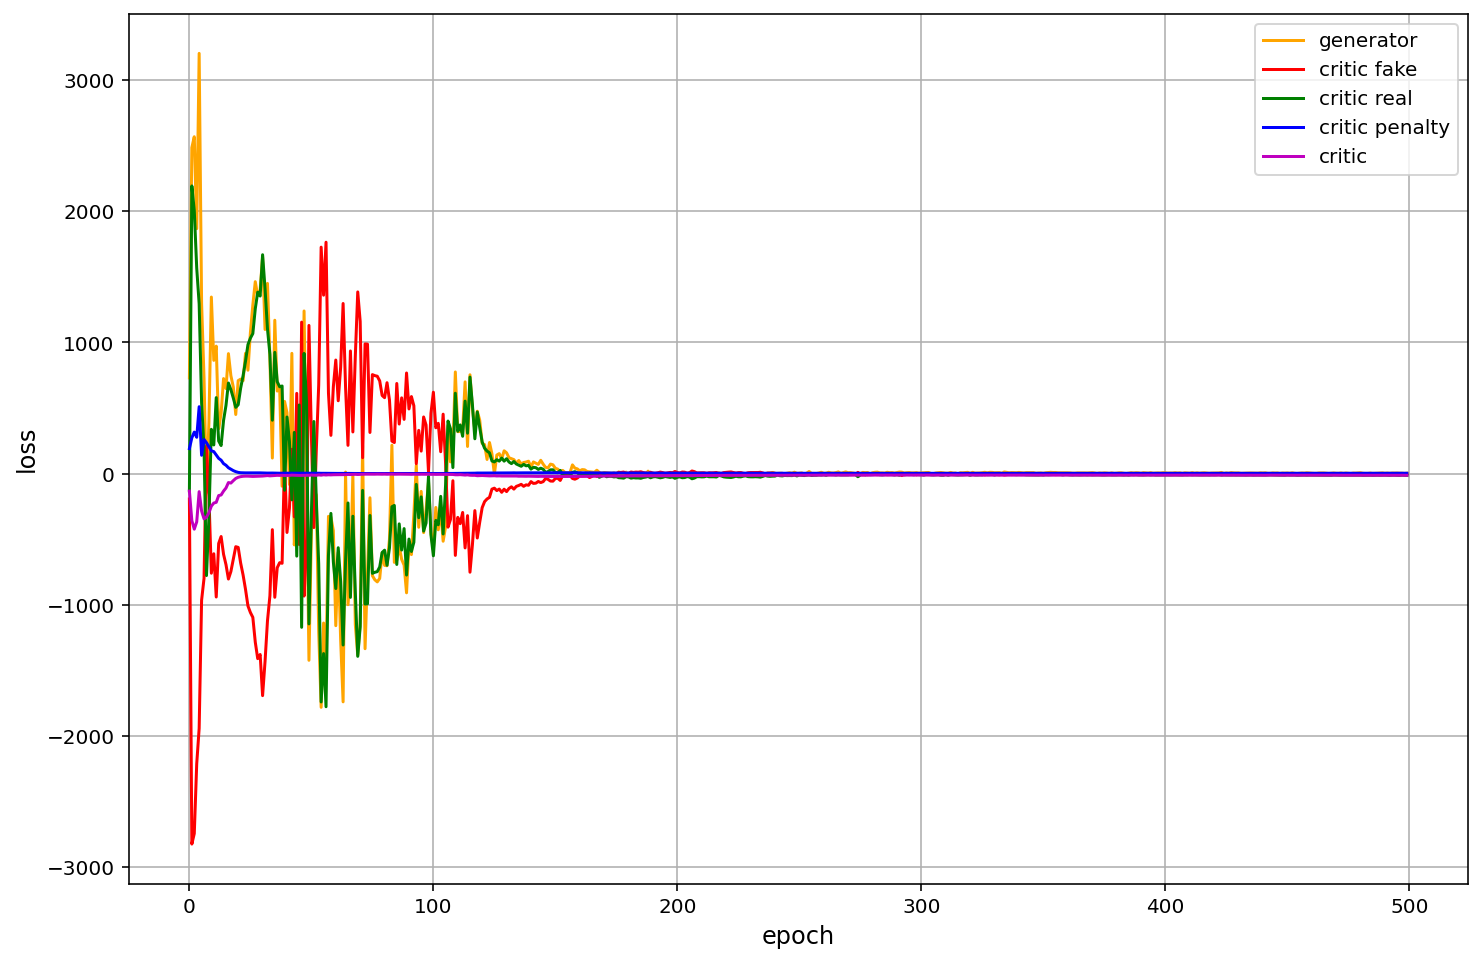

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(data['gloss'][:500], 'orange', label='generator')
plt.plot(data['cfloss'][:500], 'r', label='critic fake')
plt.plot(data['crloss'][:500], 'g', label='critic real')
plt.plot(data['cploss'][:500], 'b', label='critic penalty')
plt.plot(data['closs'][:500], 'm', label='critic')
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid()
plt.legend()
plt.show()

In [ ]:
generator = generator.cuda().eval()
print(device)
chords = torch.rand(1, 32).to(device)
style = torch.rand(1, 32).to(device)
melody = torch.rand(1, 4, 32).to(device)
groove = torch.rand(1,4, 32).to(device)
preds = generator(chords, style, melody, groove).detach()
preds = preds.cpu().numpy()
music_data = postprocess(preds)
filename = 'test.midi'
music_data.write('midi', fp=filename)

cuda:0


'test.midi'